<a href="https://colab.research.google.com/github/y2236li/Kiwi-Reasearch/blob/master/1D_Climber_all_in_one.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%load_ext autoreload

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
cd drive/My\ Drive/kiwi_research/kiwi_project

/content/drive/My Drive/kiwi_research/kiwi_project


In [4]:
from sklearn.preprocessing import MinMaxScaler
import collections
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.svm import SVR
from sklearn.metrics import r2_score
from sklearn.cross_decomposition import PLSRegression
from keras.layers import Dense, Activation
from keras.models import Sequential, load_model
from keras.optimizers import Adam

Using TensorFlow backend.


In [0]:
def calAccuracy(x):
  """
  Calculate the accuracy
  return: accuracy
  """
  if x in historical_accuracy:
    return historical_accuracy[x]
  pls2 = PLSRegression(n_components=x)
  pls2.fit(X_train, Y_train)
  Y_pred = pls2.predict(X_test)
  y = r2_score(Y_pred, Y_test)
  historical_accuracy[x] = y
  return y

def stateNormalize(scaler, detection, param_val):
  detection = np.append(detection, param_val)
  assert scaler.data_range_.shape[0] == detection.shape[0]
  return scaler.transform([detection])[0]

def stateDenormalized(scaler, cur_state):
  res = scaler.inverse_transform([cur_state])
  return (res[0][:-1], int(round(res[0][-1])))

def detect(detect_range, x):
  """
  return the accuracy of detecting area around the x
  
  """
  x_detect_range = np.array(detect_range) + x
  return [calAccuracy(pos) if pos in x_range else 0 for pos in x_detect_range]


## Global Variables

In [0]:
f_xy = open("pickles/XYtraintest.pk1", "rb")
X_train, X_test, Y_train, Y_test = pickle.load(f_xy)
f_xy.close()

f_a = open("pickles/accuracy_list.pk1", "rb")
accuracy_list = pickle.load(f_a)
f_a.close()

idle_range = 0.001 # if the change of recent steps (idle steps) did not have a change of this range. Game will be over
idle_steps = 5
x_range = range(1, 201)
detect_range = [-3, -1, 0, 1, 3] # also input dim
step_options = [-8, -3, -1, 0, 1, 3, 8] # also action space

lr = 0.01 # also alpha
one_game_steps = 300

batch_size = one_game_steps*3
gamma = 0.8

#memory variables
mem_size = one_game_steps*6
assert batch_size <= mem_size
mem_ctr = 0
state_mem = {}
onehot_action_mem = {}
reward_mem = {}
next_state_mem = {}
terminal_mem = {}

## Create a scaler for state

In [7]:
data = [[*([0]*len(detect_range)), 1], [*([1]*len(detect_range)), 200]]
scaler = MinMaxScaler()
scaler.fit(data)
scaler.data_range_.shape


(6,)

## Game Initialization

In [0]:
historical_accuracy = {}
x = 150
detection = detect(detect_range, x)
init_state = stateNormalize(scaler, detection, x)


done = False
step_ctr = 0

cur_state = init_state

## Create a Fully Connected Neural Network for Q Learning

In [9]:
fc2_dims = 200
q_model = Sequential([
        Dense(200, input_shape=(cur_state.shape[0],)),
        Activation('relu'),
        Dense(fc2_dims),
        Activation('relu'),
        Dense(len(step_options))
    ])

q_model.compile(optimizer=Adam(lr=lr), loss='mse')

In [10]:
q_model.predict(cur_state.reshape(1, 6))

array([[ 0.04637441, -0.13272649,  0.10633672, -0.06502012,  0.11232945,
        -0.05208415,  0.05450027]], dtype=float32)

In [0]:
def step(cur_state, action):
  next_x = max(min(200, int(round(stateDenormalized(scaler, cur_state)[-1])) + action), 1)
  next_state = stateNormalize(scaler, detect(detect_range, next_x), next_x)
  reward = calAccuracy(next_x)
  return (next_state, reward)

def writeMem(cur_state, next_state, action, reward, done):
  index = mem_ctr % mem_size
  state_mem[index] = cur_state
  next_state_mem[index] = next_state
  tmp_onehot = np.zeros(len(step_options), dtype=np.int64)
  tmp_onehot[step_options.index(action)] = 1
  onehot_action_mem[index] = tmp_onehot
  reward_mem[index] = reward
  terminal_mem[index] = done


## Main

In [0]:
'''Prepare Data'''
# data_path = "data/clean raw data.xlsx"
# df = pd.read_excel(data_path)
# X = df[df.columns[3:]]
# Y = df["Brix"].values
# X_matrix = X.to_numpy()
# nonzero_index = np.nonzero(X_matrix.sum(axis = 0))[0]
# X_matrix_nonzero = X_matrix[:, nonzero_index]
# X_nonzero_columns = X.columns[nonzero_index]


# while(not done):

# reset memory
mem_ctr = 0
state_mem = {}
onehot_action_mem = {}
reward_mem = {}
next_state_mem = {}
terminal_mem = {}

batch_size = one_game_steps * 2
random_walk_period = one_game_steps * 10
n_games = 40

reward_his = []


scaler_state = MinMaxScaler()

for i in tqdm(range(n_games)):
  cur_state = init_state
  for step_ctr in range(one_game_steps):
    
  # predict action
    if mem_ctr < random_walk_period:
      action = np.random.choice(step_options)
    else:
      # once random walk were done, the state in memory will be normalized
      if mem_ctr == random_walk_period:
        scaler_state.fit(np.array(list(state_mem.values())))
        state_mem = dict(zip(*(range(mem_size), scaler_state.transform(np.array(list(state_mem.values()))))))
        cur_nor_state = scaler_state.transform([cur_state])[0]

      indices = np.random.choice(len(state_mem), batch_size)

      batch_states = np.array(list(state_mem.values()))[indices]
      batch_next_states = np.array(list(next_state_mem.values()))[indices]
      batch_actions = np.array(list(onehot_action_mem.values()))[indices]
      batch_rewards = np.array(list(reward_mem.values()))[indices]

      q_matrix = q_model.predict(batch_states)
      q_next = q_model.predict(batch_next_states)

      actions_indices = np.dot(batch_actions, np.arange(len(step_options), dtype=np.int64))
      batch_indices = np.arange(batch_size, dtype=np.int64)

      q_matrix[batch_indices, actions_indices] = batch_rewards + gamma*np.max(q_next, axis=1) * done


      q_model.fit(batch_states, q_matrix, verbose=0, epochs = 1)

      action = step_options[np.argmax(q_model.predict(cur_nor_state.reshape(1, 6)))]
    
      
    next_state, reward = step(cur_state, action)
    if mem_ctr >= random_walk_period:
      next_nor_state = scaler_state.transform([next_state])[0]
      writeMem(cur_nor_state, next_nor_state, action, reward, done)
    else:
      writeMem(cur_state, next_state, action, reward, done)
    reward_his.append(reward)


    

    

    cur_state = next_state


    mem_ctr += 1


 32%|███▎      | 13/40 [00:43<04:10,  9.27s/it]

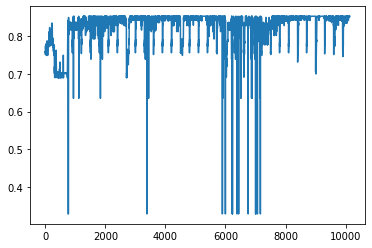

In [0]:
plt.plot(reward_his) # epoch = 1 trial 1

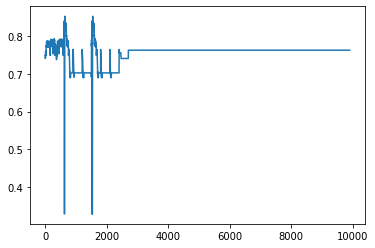

In [87]:
plt.plot(reward_his) # normalized state epoch = 1 trial 1

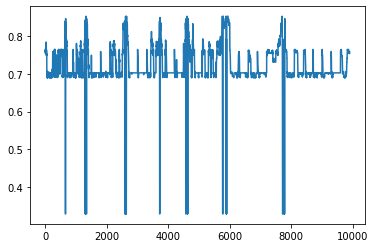

In [13]:
plt.plot(reward_his) # normalized state epoch = 1 trial 2

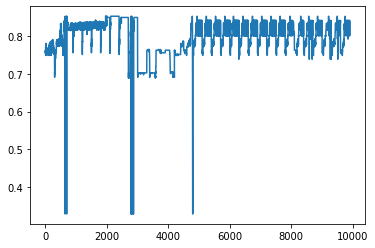

In [0]:
plt.plot(reward_his) # epoch = 20 trial 1

In [0]:
accuracy_list[150]

0.7645200307759966

## Visualize Optimization Process

[[0.70339325 0.73238515 0.77228981 0.97942405 0.97252373 0.45652174]]
[[0.69049589 0.71854882 0.73238515 0.97686414 0.975566   0.44565217]]
[[0.68494777 0.72282729 0.71854882 0.97202046 0.97942509 0.43478261]]
[[0.66171663 0.70957359 0.72282729 0.97034098 0.97686519 0.42391304]]
[[0.69960419 0.70387218 0.70957359 0.97086031 0.97202149 0.41304348]]
[[0.71195569 0.67999919 0.70387218 0.96925156 0.97034202 0.40217391]]
[[0.74120431 0.71893354 0.67999919 0.96855951 0.97086135 0.39130435]]
[[0.76104822 0.7316263  0.71893354 0.96566177 0.96925259 0.38043478]]
[[0.70718247 0.76168303 0.7316263  0.97038768 0.96856054 0.36956522]]
[[0.67210275 0.7820752  0.76168303 0.97192835 0.9656628  0.35869565]]
[[0.67836206 0.7267212  0.7820752  0.97557668 0.97038872 0.34782609]]
[[0.67961796 0.69067226 0.7267212  0.97805191 0.97192938 0.33695652]]
[[0.6889463  0.69710452 0.69067226 0.97133296 0.97557772 0.32608696]]
[[0.68147588 0.69839512 0.69710452 0.96695729 0.97805295 0.31521739]]
[[0.66421638 0.70798

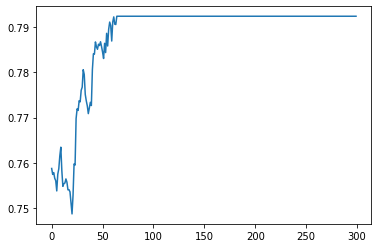

In [20]:
prediction = []
cur_state = init_state
for step_ctr in range(one_game_steps):
  action = step_options[np.argmax(q_model.predict(scaler_state.transform(cur_state.reshape(1, 6))))]
  print(scaler_state.transform(cur_state.reshape(1, 6)))
  # print(stateDenormalized(scaler, cur_state))
  next_state, reward = step(cur_state, action)
  prediction.append(reward)
  cur_state = next_state
plt.plot(prediction)
# prediction

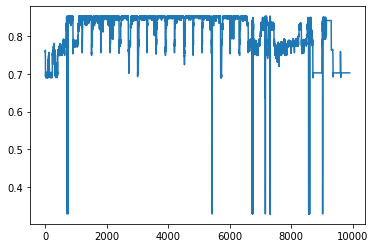

In [26]:
plt.plot(reward_his) # epoch = 20 trial 2

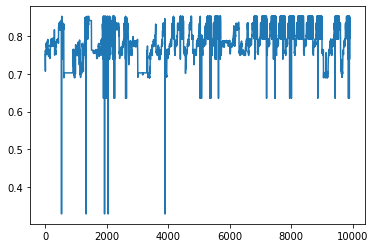

In [46]:
plt.plot(reward_his) # epoch = 20 trial 4

In [64]:
scaler_state = MinMaxScaler()
scaler_state.fit(np.array(list(state_mem.values())))
scaler_state.transform(np.array(list(state_mem.values())))

array([0., 0., 0., 0., 0., 0.])

In [66]:
scaler_state.transform([cur_state])

array([[0.        , 0.58475177, 0.47644262, 0.92923334, 0.95220097,
        0.00505051]])

(array([176.,  33.,  18.,  10., 740.,  52., 109.,  53.,  11.,  12.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

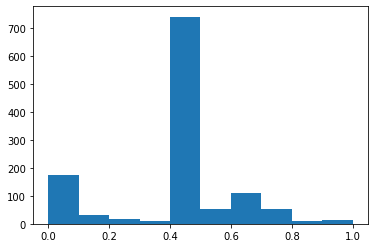

In [84]:
plt.hist(np.sort(np.array(list(state_mem.values()))[:, 0]))